In [13]:
import random
import torch
import torch.utils.data as data_utils
from data.torchfsdd.dataset import TorchFSDDGenerator
from data.augmentations.randphase import AllPassFilter
from torch_audiomentations import *

In [32]:
# Initialize augmentation callable
audio_augmentation = Compose(
    p=0.5,
    transforms=[
        Gain(
            min_gain_in_db=-15.0,
            max_gain_in_db=5.0,
            p=0.1,
            sample_rate = 8000,
            output_type='dict'
        ),
        PitchShift(p=0.05, p_mode='per_example',
            sample_rate = 8000,
            output_type='dict'),
        AddColoredNoise(p=1,
            min_snr_in_db = 3,
            sample_rate = 8000),
        Shift(-0.05, 0.2, p=0.1,
            sample_rate = 8000,
            output_type='dict'),
        PolarityInversion(p=0.1,
            sample_rate = 8000,
            output_type='dict'),
        AllPassFilter(sample_rate=8000,
            output_type='dict')
    ], output_type='dict'
)
# Initialize a generator for a local version of FSDD
fsdd = TorchFSDDGenerator(version='local', 
                        path='/home/theloni/audio-rc-rtl/exploration/data/torchfsdd/recordings',
                        transforms=audio_augmentation)

# Create two Torch datasets for a train-test split from the generator
train_set, test_set = fsdd.train_test_split(test_size=0.15)
# no transforms on validation
fsdd = TorchFSDDGenerator(version='local',
                          path='/home/theloni/audio-rc-rtl/exploration/data/torchfsdd/recordings')
_, _, val_set  = fsdd.train_val_test_split(test_size=0.05, val_size=0.1)


def collate_fn(batch):
    """Collects together sequences into a single batch, arranged in descending length order."""
    batch_size = len(batch)

    # Sort the (sequence, label) pairs in descending order of duration
    batch.sort(key=(lambda x: len(x[0])), reverse=True)
    # Shape: list(tuple(tensor(TxD), int))

    # Create list of sequences, and tensors for lengths and labels
    sequences,  lens, labels = [], [], torch.zeros(batch_size, dtype=torch.long)
    for i, (sequence, label) in enumerate(batch):
        labels[i] = label
        lens.append(sequence.numel()) # mono so valid
        sequences.append(sequence)

    # Combine sequences into a padded matrix
    stacked_sequences = torch.stack(sequences)#torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    # Shape: (B x T_max x D)

    return stacked_sequences, labels
    # Shapes: (B x T_max x D), (B,), (B,)

In [40]:
train_gen = data_utils.DataLoader(train_set, collate_fn=collate_fn, batch_size=64, shuffle=True, pin_memory=True)
val_gen = data_utils.DataLoader(val_set, collate_fn=collate_fn, batch_size=len(val_set))
test_gen = data_utils.DataLoader(test_set, collate_fn=collate_fn, batch_size=len(test_set))

In [41]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display

In [42]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate, NFFT=128, noverlap=64)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


In [43]:
sample_batch, labels = next(iter(train_gen))
sample_batch.shape, labels.shape

(torch.Size([64, 1, 8000]), torch.Size([64]))

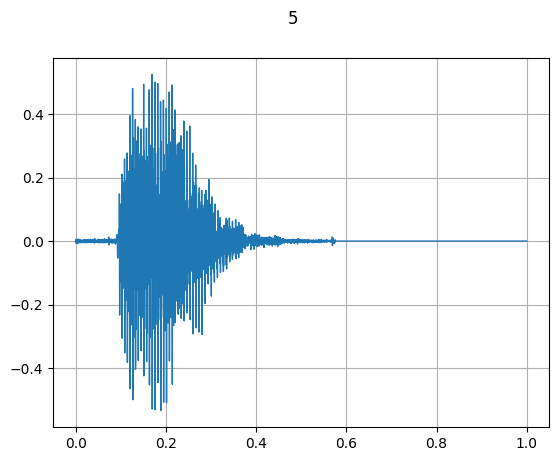

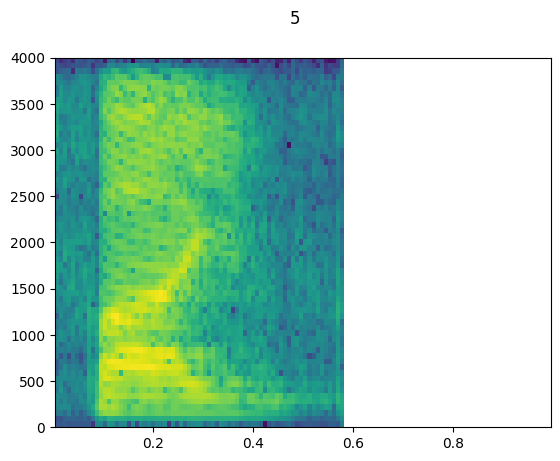

In [44]:
idx = random.randint(0,sample_batch.shape[0])
waveform = sample_batch[idx]
label = labels[idx]
sample_rate = 8000
plot_waveform(waveform, sample_rate, title=label.item())
plot_specgram(waveform, sample_rate, title=label.item())
play_audio(waveform, sample_rate)